In [145]:
import numpy as np
from src.cyc_gbm import CycGBM
from src.cyc_gbm.utils import tune_kappa
from src.cyc_gbm.distributions import initiate_distribution
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import pandas as pd

In [165]:
n = 10000
p = 9
random_state = 11
dist = 'normal'

rng = np.random.default_rng(seed = random_state)
distribution = initiate_distribution(dist = dist)

X = np.concatenate([np.ones((1, n)), rng.normal(0, 1, (p - 1, n))]).T
z0 = (
    1.5 * X[:, 1]
    + 2 * X[:, 3]
    - 0.65 * X[:, 2] ** 2
    + 0.5 * np.abs(X[:, 3]) * np.sin(0.5 * X[:, 2])
    + 0.45 * X[:, 4] * X[:, 5] ** 2
)
z1 = 1 + 0.02 * X[:, 2] + 0.5 * X[:, 1] * (X[:, 1] < 2) + 1.8 * (X[:, 5] > 0)
z = np.stack([z0, z1])
y = distribution.simulate(z = z, random_state = random_state)

X_train, X_test, y_train, y_test, z_train, z_test = train_test_split(X, y, z, test_size=0.2, random_state=random_state)
z_train = z_train.T
z_test = z_test.T

ValueError: Found input variables with inconsistent numbers of samples: [10000, 10000, 2]

In [163]:
def moving_average(x):
    return np.convolve(x, np.ones(100), 'valid') / 100

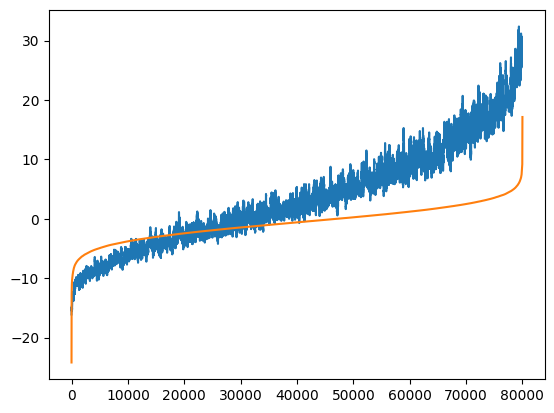

In [164]:
sort_order = np.argsort(z_train[0])
plt.plot(
    moving_average(y_train[sort_order]),
)
plt.plot(z_train[0][sort_order])

In [147]:
# Set hyperparameters
kappa = [23, 17]
eps = 0.01
max_depth = 3
min_samples_leaf = 5

In [148]:
gbm = CycGBM(kappa = kappa,
             dist = 'normal',
             eps = eps,
             max_depth = max_depth,
             min_samples_leaf = min_samples_leaf)
gbm.fit(X_train,y_train)

In [149]:
losses = pd.DataFrame(columns = ['train','test'], index=['intercept','gbm'])
losses.loc['intercept','train'] = distribution.loss(y = y_train, z = gbm.z0).mean()
losses.loc['intercept','test'] = distribution.loss(y = y_test, z = gbm.z0).mean()
losses.loc['gbm','train'] = distribution.loss(y = y_train, z = gbm.predict(X_train)).mean()
losses.loc['gbm','test'] = distribution.loss(y = y_test, z = gbm.predict(X_test)).mean()
print(losses)

              train      test
intercept  3.247857  3.281021
gbm        2.945848   2.96164


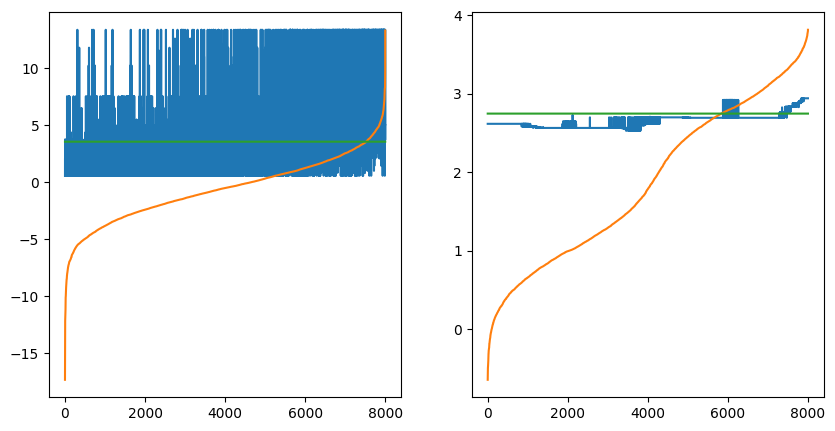

In [150]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot the mean, intercept and gbm estimates
sort_order = np.argsort(z_train[0])
axs[0].plot(gbm.predict(X_train)[0][sort_order], label = 'gbm')
axs[0].plot(z_train[0][sort_order], label = 'true')
axs[0].plot(gbm.z0[0]*np.ones(len(z_train[0])), label = 'intercept')

sort_order = np.argsort(z_train[1])
axs[1].plot(gbm.predict(X_train)[1][sort_order], label = 'gbm')
axs[1].plot(z_train[1][sort_order], label = 'true')
axs[1].plot(gbm.z0[1]*np.ones(len(z_train[1])), label = 'intercept')


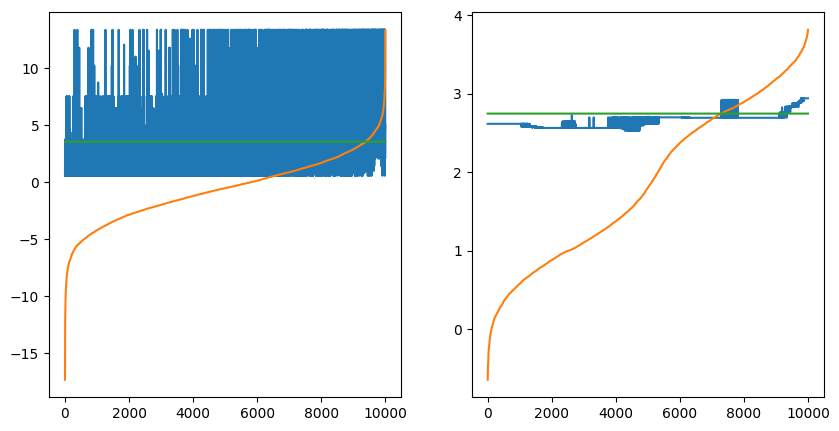

In [167]:
# Now the same plots but for the entire data set
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot the mean, intercept and gbm estimates
sort_order = np.argsort(z[0])
axs[0].plot(gbm.predict(X)[0][sort_order], label = 'gbm')
axs[0].plot(z[0][sort_order], label = 'true')
axs[0].plot(gbm.z0[0]*np.ones(len(z[0])), label = 'intercept')

sort_order = np.argsort(z[1])
axs[1].plot(gbm.predict(X)[1][sort_order], label = 'gbm')
axs[1].plot(z[1][sort_order], label = 'true')
axs[1].plot(gbm.z0[1]*np.ones(len(z[1])), label = 'intercept')
